<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Машинное обучение и майнинг данных"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# Занятие 4. Продвинутые методы классификации и регрессии. Переобучение

## Часть 2. Random Forest

Метод случайных лесов основан на бэггинге и методе случайных подпространств над решающими деревьями. Данный алгоритм машинного обучения был предложен Лео Брейманом и Адель Катлер. Решающие деревья являются хорошим семейством базовых классификаторов для бэггинга, поскольку они достаточно сложны и могут достигать нулевой ошибки на любой выборке. Метод случайных подпространств позволяет снизить коррелированность между деревьями и избежать переобучения.

Алгоритм построения случайного леса, состоящего из $N$ деревьев, выглядит следующим образом:
* Для каждого $n = 1, \dots, N$:
     * Сгенерировать выборку $X_n$ с помощью bootstrap.
     * Построить решающее дерево $b_n$ по выборке $X_n$:
         - дерево строится, пока в каждом листе не более $n_\text{min}$ объектов.
         - при каждом разбиении сначала выбирается $m$ случайных признаков из $n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
* Итоговый классификатор $a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$.

Рекомендуется в задачах классификации брать $m = \sqrt{n}$, а в задачах регрессии — $m = \frac{n}{3}$, где $n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по
одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять.

Таким образом, случайный лес - это бэггинг над решающими деревьями, при обучении которых для каждого разбиения признаки выбираются из некоторого случайного подмножества признаков.

## Примеры
Метод случайного леса реализован классом sklearn.ensemble.RandomForestClassifier (или RandomForestRegressor для задач восстановления регрессии). Основные параметры: 
- n_estimators - число деревьев в "лесу"
- criterion - критерий для разбиения выборки в вершине
- max_features - число признаков, по которым будет ищется разбиение
- min_samples_leaf - минимальное число объектов в листе

Рассмотрим его применение на задаче восстановления одномерной регрессии.

Populating the interactive namespace from numpy and matplotlib


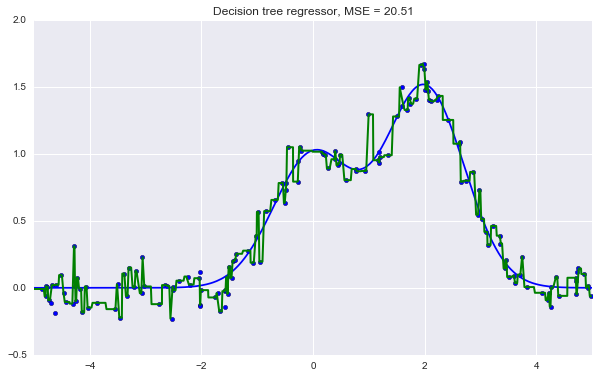

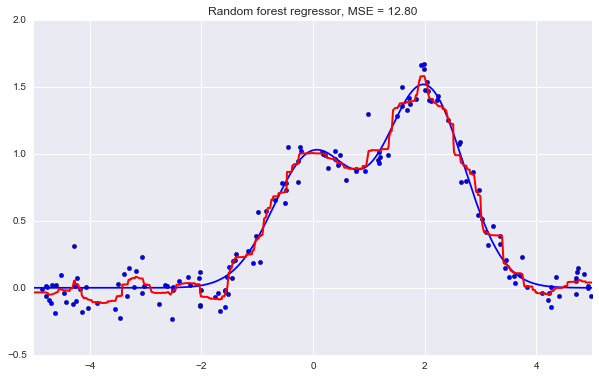

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
     
n_train = 150        
n_test = 1000       
noise = 0.1

# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# One decision tree regressor
dtree = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
d_predict = dtree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" 
          % np.sum((y_test - d_predict) ** 2))

# Random Forest
rf = RandomForestRegressor(n_estimators=50, 
                           min_samples_leaf=3, random_state=42).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)
plt.xlim([-5, 5])
plt.title("Random forest regressor, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))

Рассмотрим использование случайных лесов в задаче классификации.

In [2]:
from sklearn.svm import SVC
from sklearn.cross_validation import KFold
import sys
if sys.version_info.major == 2:
    from urllib import urlopen
if sys.version_info.major == 3:    
    from urllib.request import urlopen
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split

# Loading Pima Indians Diabetes data from UCI Machine learning repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
raw_data = urlopen(url)
data = np.loadtxt(raw_data, delimiter=",")

X_train, X_test, y_train, y_test = train_test_split(data[:, :8], 
                                                    data[:, 8], 
                                                    random_state=1)

dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
rf = RandomForestClassifier(n_estimators=200, 
                            max_features="sqrt", 
                            random_state=42).fit(X_train, y_train)

print("Decision tree accuracy: %.2f" % dt.score(X_test, y_test))
print("Random forest accuracy: %.2f" % rf.score(X_test, y_test))

Decision tree accuracy: 0.71
Random forest accuracy: 0.81


## Полезные ссылки:
- [Random forest](https://en.wikipedia.org/wiki/Random_forest)
- [Статья](http://blog.yhathq.com/posts/random-forests-in-python.html) Random Forests in Python